In [1]:
from tqdm import tqdm
import pandas as pd
import json
import os
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import wandb
api = wandb.Api()

# Pull and Dedup Data

In [2]:
setting_columns = [
    # Overall
    "tag",
    # "seed",
    "_timestamp",

    # Interventions
    "interventions", "edit", "unlearn", "compression", "model_name",

    # Editing
    # "edit_set", 
    "edit_dataset", "number_of_edits",

    # Unlearning
    "rmu_layer_id",

    # Compression
    "wbits", "compression_dataset", "sparsity_ratio",
]
evaluation_columns = [
    "qa_question_count_limit",  # An artifical max number of questions to ask during evaluation. Should be none when not debugging.
    "mmlu accuracy",            # The accuracy of the model on the MMLU dataset. This measures overall model utility. Llama-3 should be ~62%
    "wmdp_bio accuracy",        # The accuracy of the model on the WMDP bio split. This is the unlearning target. Should be ~25% when RMU is applied.
    "wmdp_cyber accuracy",      # The accuracy of the model on the WMDP cyber split. This is the unlearning target. Should be ~25% when RMU is applied.
    "PPL",                      # TODO:
    "PPL edits",                # Perplexity for the edits. Should be low when editing is applied.
    "PPl QA",                   # Perplexity for the QA. Should be low when QA is applied.
    "Generalization",           # TODO: 
    "FLOPs",                    # TODO: 
    "Success recall",           # TODO:
    "Generalization recall",    # TODO:
    "Locality",                 # TODO:
    "Average bits",             # TODO:
    "Rewrite accuracy",         # TODO:
    "PPl edits unmasked",       # TODO:
    "Local recall",             # TODO:
    "Latency",                  # TODO:
]
relevant_columns = setting_columns + evaluation_columns

In [3]:
# Composable_Interventions has all the results
project_paths = [
    'dri-ice/Composable_Interventions',
    # 'dri-ice/AK_Tests'
]

filter_dict = { "state": "finished" }
data_frames = []
for project_path in project_paths:
    runs = api.runs(project_path, filters=filter_dict)
    
    # Iterate over eachrun and capture the c        onfig and summary metrics
    for run in tqdm(runs, desc=project_path):
        try:
            run_start_datetime = datetime.fromtimestamp(run.summary_metrics["_timestamp"])
            start_cutoff = datetime.strptime("2024-05-18 00:00:00", "%Y-%m-%d %H:%M:%S")
            end_cutoff = datetime.strptime("2024-05-31 00:00:00", "%Y-%m-%d %H:%M:%S")
            if run_start_datetime < start_cutoff or run_start_datetime > end_cutoff:
                continue

            skip_tags = ["test", "hparam_search"]
            should_skip = False
            for tag in skip_tags:
                if tag in run.config["tag"].lower():
                    should_skip = True
            
            if should_skip:
                continue

            config_frame = pd.DataFrame([run.config])
            summary_frame = pd.DataFrame([run.summary_metrics])
            combined_frame = pd.concat([config_frame, summary_frame], axis=1)
            data_frames.append(combined_frame)
        except Exception as e:
            print(f"Error processing run {run.id}: {e}")

# Sort by 'tag' and '_timestamp' in descending order to have the most recent run first
all_runs_df = pd.concat(data_frames, ignore_index=True)[relevant_columns]
all_runs_df["interventions"] = all_runs_df["interventions"].astype(str)

# WARNING: WHAT DOES EDIT SET 50 MEAN COMPARED TO EDIT SET 1?
# all_runs_df = all_runs_df[all_runs_df["edit_set"] == 50]
# all_runs_df_sorted = all_runs_df.sort_values(by=['tag', '_timestamp'], ascending=[True, False])
all_runs_df["date"] = pd.to_datetime(all_runs_df["_timestamp"], unit='s')
all_runs_df_sorted = all_runs_df.sort_values(by=['_timestamp'], ascending=[False])
all_runs_df_sorted = all_runs_df_sorted[all_runs_df_sorted["qa_question_count_limit"].isnull()]

dri-ice/Composable_Interventions: 100%|██████████| 371/371 [00:01<00:00, 210.88it/s]


Error processing run n0iel6ok: '_timestamp'
Error processing run xr5mede5: '_timestamp'
Error processing run 27f8pxs0: '_timestamp'


In [4]:
# TODO: Ensure that rmu_layer_id is 3. This was originaly set to 5, but decided to rerun the evals last minute with a better hyperparameter.
# Use older RMU experiments
# all_runs_df_sorted = all_runs_df_sorted[all_runs_df_sorted["rmu_layer_id"] != 3]

In [5]:
# Drop duplicates, keeping only the first occurrence (which is the most recent due to sorting)
# all_runs_df_deduplicated = all_runs_df_sorted.drop_duplicates(subset=[col for col in setting_columns if col not in ["_timestamp", "tag", "date"]], keep="first")
all_runs_df_deduplicated = all_runs_df_sorted.drop_duplicates(subset="tag", keep="first")
all_runs_df_deduplicated["interventions"] = all_runs_df_deduplicated["interventions"].apply(lambda x : ast.literal_eval(x))

rename_dict = {
    "meta-llama/Meta-Llama-3-8B" : "Llama-3 (8b)",
    "ft" : "Fine-tune",
    "memit" : "MEMIT",
    "lora" : "LoRA",
    "wanda" : "Wanda",
    "sparsegpt" : "SparseGPT",
    "gptq" : "GPTQ",
    "awq" : "AWQ",
    "rmu" : "RMU",
}
metrics = all_runs_df_deduplicated
metrics["model_name"] = metrics["model_name"].apply(lambda x : rename_dict.get(x, None))
metrics["edit"] = metrics["edit"].apply(lambda x : rename_dict.get(x, None))
metrics["compression"] = metrics["compression"].apply(lambda x : rename_dict.get(x, None))
metrics["unlearn"] = metrics["unlearn"].apply(lambda x : rename_dict.get(x, None))
all_runs_df_deduplicated = metrics
display(all_runs_df_deduplicated.value_counts("tag"))
print(f"Number of experiments: {len(all_runs_df_deduplicated)}")

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_99252/3643092841.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_runs_df_deduplicated["interventions"] = all_runs_df_deduplicated["interventions"].apply(lambda x : ast.literal_eval(x))
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_99252/3643092841.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics["model_name"] = metrics["model_name"].apply(lambda x : rename_dict.get(x, None))
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc00

tag
AWQ2bit-to-ft             1
ft-to-GPTQ8bit            1
lora-to-GPTQ8bit          1
lora-to-SparseGPT0.25%    1
lora-to-SparseGPT0.35%    1
                         ..
Wanda0.25%-to-memit       1
Wanda0.35%-to-ft          1
Wanda0.35%-to-lora        1
Wanda0.35%-to-memit       1
wanda0.75\%-rmu           1
Name: count, Length: 209, dtype: int64

Number of experiments: 209


In [6]:
# TODO: Get a second pair of eyes on this this math

# Math for determining number of interventions
awq_settings = 6
gptq_settings = 4 # only support quantize to [2, 3, 4, 8] bits.
wanda_count = 6
sparsegpt_count = 6
editor_settings = 3
composition_factor = 2

editor_count = composition_factor * (awq_settings + gptq_settings + wanda_count + sparsegpt_count + 1) * editor_settings
print(editor_count // 2)

rmu_count = composition_factor * (awq_settings + gptq_settings + wanda_count + sparsegpt_count + editor_settings)
print(rmu_count)

69
50


In [7]:
data = all_runs_df_deduplicated

categories = {
    "No Intervention": data[data["interventions"].apply(lambda x: x == [])].copy(),
    "Editing": data[data["interventions"].apply(lambda x: x == ["edit"])].copy(),
    "Compression": data[data["interventions"].apply(lambda x: x == ["compress"])].copy(),
    "Edit to Compression": data[data["interventions"].apply(lambda x: x == ["edit", "compress"])].copy(),
    "Compression to Edit": data[data["interventions"].apply(lambda x: x == ["compress", "edit"])].copy(),
    "Unlearn": data[data["interventions"].apply(lambda x: x == ["unlearn"])].copy(),
    "Edit to Unlearn": data[data["interventions"].apply(lambda x: x == ["edit", "unlearn"])].copy(),
    "Unlearn to Edit": data[data["interventions"].apply(lambda x: x == ["unlearn", "edit"])].copy(),
    "Compress to Unlearn": data[data["interventions"].apply(lambda x: x == ["compress", "unlearn"])].copy(),
    "Unlearn to Compress": data[data["interventions"].apply(lambda x: x == ["unlearn", "compress"])].copy()
}

assert len(categories["No Intervention"]) == 1, f"{len(categories['No Intervention'])} != 1"
assert len(categories["Editing"]) == 3, f"{len(categories['Editing'])} != 3"

# display(categories["Compression"])
assert len(categories["Compression"]) == (awq_settings + gptq_settings + wanda_count + sparsegpt_count), f"{len(categories['Compression'])} != {awq_settings + gptq_settings + wanda_count + sparsegpt_count}"

# assert len(categories["Edit to Compression"]) == editor_count // 2, f"{len(categories['Edit to Compression'])} != {editor_count // 2}"

assert len(categories["Compression to Edit"]) == (editor_count // 2 )- 3, f"{len(categories['Compression to Edit'])} != {editor_count // 2}" # TODO: Fix this by getting the latest results
assert len(categories["Unlearn"]) == 1, f"{len(categories['Unlearn'])} != 1"
assert len(categories["Edit to Unlearn"]) == 3
assert len(categories["Unlearn to Edit"]) == 3, f"{len(categories['Unlearn to Edit'])} != 3"

# display(categories["Compress to Unlearn"])
# assert len(categories["Compress to Unlearn"]) == rmu_count // 2, f"{len(categories['Compress to Unlearn'])} != {rmu_count // 2}"

# display(categories["Unlearn to Compress"])
# assert len(categories["Unlearn to Compress"]) == rmu_count // 2, f"{len(categories['Unlearn to Compress'])} != {rmu_count // 2}"


# Create Results Tables

In [8]:
def format_flops(value):
    """ Format FLOPs with three significant figures and appropriate suffix. """
    try:
        if isinstance(value, str):
            value = clean_numeric_value(value)
        if abs(value) < 1e6:  # Less than 1 million (below Mega)
            return "{:.3g}k".format(value / 1e3)
        elif abs(value) < 1e9:  # Mega to Giga range
            return "{:.3g}M".format(value / 1e6)
        elif abs(value) < 1e12:  # Giga to Tera range
            return "{:.3g}G".format(value / 1e9)
        else:  # Tera and above
            return "{:.3g}T".format(value / 1e12)
    except Exception as e:
        print(f"Error formatting FLOPs value {value}: {e}")
        return "---"

def escape_latex_special_chars(s):
    """ Escape special characters in LaTeX strings. """
    return str(s).replace('%', '\\%').replace('_', '\\_').replace('&', '\\&').replace('#', '\\#').replace('$', '\\$')

def clean_numeric_value(value):
    """ Convert a string with units to a numeric value. """
    try:
        value = str(value)
        if ' TFLOPS' in value:
            return float(value.replace(' TFLOPS', '')) * 1e12
        if ' GFLOPS' in value:
            return float(value.replace(' GFLOPS', '')) * 1e9
        if ' MFLOPS' in value:
            return float(value.replace(' MFLOPS', '')) * 1e6
        if ' kFLOPS' in value:
            return float(value.replace(' kFLOPS', '')) * 1e3
        return pd.to_numeric(value, errors='coerce')
    except Exception as e:
        print(f"Error cleaning value {value}: {e}")
        return pd.NA

def categorize_and_generate_latex(data):
    # Define categories based on the provided criteria
    categories = {
    "No Intervention": data[data['interventions'].apply(lambda x: x == [])].copy(),
    "Editing": data[data['interventions'].apply(lambda x: x == ['edit'])].copy(),
    "Compression": data[data['interventions'].apply(lambda x: x == ['compress'])].copy(),
    "Edit to Compression": data[data['interventions'].apply(lambda x: x == ['edit', 'compress'])].copy(),
    "Compression to Edit": data[data['interventions'].apply(lambda x: x == ['compress', 'edit'])].copy(),
    "Unlearn": data[data['interventions'].apply(lambda x: x == ['unlearn'])].copy(),
    "Edit to Unlearn": data[data['interventions'].apply(lambda x: x == ['edit', 'unlearn'])].copy(),
    "Unlearn to Edit": data[data['interventions'].apply(lambda x: x == ['unlearn', 'edit'])].copy(),
    "Compress to Unlearn": data[data['interventions'].apply(lambda x: x == ['compress', 'unlearn'])].copy(),
    "Unlearn to Compress": data[data['interventions'].apply(lambda x: x == ['unlearn', 'compress'])].copy()
}
    # Clean numeric columns
    for col in ["FLOPs", "Latency"]:
        if col in data.columns:
            data.loc[:, col] = data[col].apply(clean_numeric_value)
            data.loc[:, col] = pd.to_numeric(data[col], errors='coerce')  # Ensure all values are numeric

    # Column mappings
    column_mappings = {
        "Success": "Rewrite accuracy",
        "Generalization": "Generalization",
        "Locality": "Locality",
        "Avg. Bits": "Average bits",
        "FLOPs": "FLOPs",
        "PPL": "PPL",
        "MMLU": "mmlu accuracy",
        "WMDP Bio": "wmdp_bio accuracy",
        "WMDP Cyber": "wmdp_cyber accuracy"
    }
    latex_columns = ["Success", "Generalization", "Locality", "Avg. Bits", "FLOPs", "PPL", "MMLU", "WMDP Bio", "WMDP Cyber"]

    # Initialize output string
    output_str = ""

    for category, group in categories.items():
        if group.empty:
            continue
        # output_str += f"\\textbf{{{category}}} \\\\ \\midline\n"
        for _, row in group.iterrows():
            # Calculate mean and std for each relevant column within the group
            stats = {}
            for latex_col, csv_col in column_mappings.items():
                if csv_col in row.index:
                    value = row[csv_col]
                    if pd.isna(value):
                        stats[latex_col] = "---"
                    else:
                        # Custom formatting for FLOPs and Latency
                        if latex_col == "FLOPs":
                            mean_str = format_flops(value)
                            stats[latex_col] = escape_latex_special_chars(mean_str)
                        elif latex_col == "Latency":
                            mean_str = f"{value:.3f}s"
                            stats[latex_col] = escape_latex_special_chars(mean_str)
                        else:
                            mean_str = f"{value:.3f}"
                            stats[latex_col] = escape_latex_special_chars(mean_str)
                else:
                    stats[latex_col] = "---"

            # Prepare the LaTeX row for the current group
            latex_row = escape_latex_special_chars(row['tag'])  # Use the tag name directly without escaping
            for column in latex_columns:
                latex_row += " & " + stats.get(column, "---")
            latex_row += " \\\\"

            # Append to output string
            output_str += latex_row + "\n"
        
        output_str += "\\midrule\n"

    return output_str

latex_rows_with_categories = categorize_and_generate_latex(all_runs_df_deduplicated)
print(latex_rows_with_categories)

None & 0.009 & 0.021 & 0.027 & 16.000 & 1.92T & 5.540 & 0.621 & 0.714 & 0.442 \\
\midrule
lora\_Edit & 1.000 & 0.647 & 0.030 & 16.000 & 1.79T & 21.656 & 0.607 & 0.700 & 0.444 \\
memit\_Edit & 0.990 & 0.887 & 0.050 & 16.000 & 1.92T & 5.570 & 0.602 & 0.687 & 0.435 \\
ft\_Edit & 1.000 & 0.769 & 0.117 & 16.000 & 1.92T & 5.570 & 0.611 & 0.690 & 0.438 \\
\midrule
Compress\_GPTQ8bit & 0.009 & 0.021 & 0.024 & 8.250 & -0.001k & 5.539 & 0.622 & 0.713 & 0.439 \\
Compress\_GPTQ4bit & 0.000 & 0.009 & 0.018 & 4.250 & -0.001k & 14.088 & 0.600 & 0.682 & 0.441 \\
Compress\_GPTQ2bit & 0.000 & 0.000 & 0.023 & 2.250 & -0.001k & 2089.334 & 0.237 & 0.254 & 0.255 \\
Compress\_AWQ4bit & 0.000 & 0.011 & 0.027 & 4.250 & -0.001k & 5.911 & 0.598 & 0.687 & 0.456 \\
Compress\_AWQ8bit & 0.009 & 0.021 & 0.027 & 8.250 & -0.001k & 5.540 & 0.621 & 0.713 & 0.444 \\
Compress\_AWQ2bit & 0.000 & 0.000 & 0.000 & 2.250 & -0.001k & 1748954.750 & 0.269 & 0.240 & 0.246 \\
Compress\_SparseGPT0.65\% & 0.009 & 0.004 & 0.018 & 6.250

# Create Plots

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the font family to serif
plt.rcParams["font.family"] = "serif"

# Seaborn settings
sns.set_context("notebook")
sns.set_palette("colorblind")
sns.color_palette("pastel")

# plotting constants
TITLE_FONT_SIZE = 18
LEGEND_FONT_SIZE = 12
WSPACE = 0.3
FIGURE_HEIGHT = 3
LINE_WIDTH = 2
FIG_SIZE = 3
MARKER_SIZE = 8
X_LABEL_ROTATION = 20

# Set colors for compositons with compression
colors = {"Wanda": "C1", "SparseGPT": "C2", "AWQ": "C3", "GPTQ": "C4"}

## Plot: Composability Heatmaps

In [10]:
intervention_names = [intervention for intervention in list(data["edit"].unique()) + list(data["unlearn"].unique()) + list(data["compression"].unique()) if intervention is not None]
intervention_type = {
    "LoRA": "edit",
    "MEMIT": "edit",
    "Fine-tune": "edit",
    "SparseGPT": "compression",
    "Wanda": "compression",
    "GPTQ": "compression",
    "AWQ": "compression",
    "RMU": "unlearn"
}
default_value = None

mmlu_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
wmdp_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
rewrite_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
for first_intervention in intervention_names:
    for second_intervention in intervention_names:
        first_intervention_type = intervention_type[first_intervention]
        second_intervention_type = intervention_type[second_intervention]
        if first_intervention_type == second_intervention_type:
            continue

        compositions = data[(data[first_intervention_type] == first_intervention) & (data[second_intervention_type] == second_intervention)]
        if first_intervention in ["SparseGPT", "Wanda"] or second_intervention in ["SparseGPT", "Wanda"]:
            compositions = compositions[compositions["sparsity_ratio"] == 0.25]
        elif first_intervention in ["GPTQ", "AWQ"] or second_intervention in ["GPTQ", "AWQ"]:
            compositions = compositions[compositions["wbits"] == 4]
        
        assert len(compositions) == 2, f"Expected 2 compositions for {first_intervention} and {second_intervention}, but found {len(compositions)}"
        
        mmlu_diff = abs(compositions["mmlu accuracy"].iloc[0] - compositions["mmlu accuracy"].iloc[1]).round(4)
        mmlu_heatmap_data[first_intervention][second_intervention] = mmlu_diff
        
        avg_wmdp_diff = abs(((compositions.iloc[0]["wmdp_cyber accuracy"] + compositions.iloc[0]["wmdp_bio accuracy"]) / 2) - ((compositions.iloc[1]["wmdp_cyber accuracy"] + compositions.iloc[1]["wmdp_bio accuracy"]) / 2)).round(4)
        wmdp_heatmap_data[first_intervention][second_intervention] = avg_wmdp_diff
        
        rewrite_diff = abs(compositions["Rewrite accuracy"].iloc[0] - compositions["Rewrite accuracy"].iloc[1]).round(4)
        rewrite_heatmap_data[first_intervention][second_intervention] = rewrite_diff
        
# print("MMLU")
# display(mmlu_heatmap_data)

# print("WMDP")
# display(wmdp_heatmap_data)

# print("Rewrite")
# display(rewrite_heatmap_data)

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_99252/160959247.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mmlu_heatmap_data[first_intervention][second_intervention] = mmlu_diff
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc00

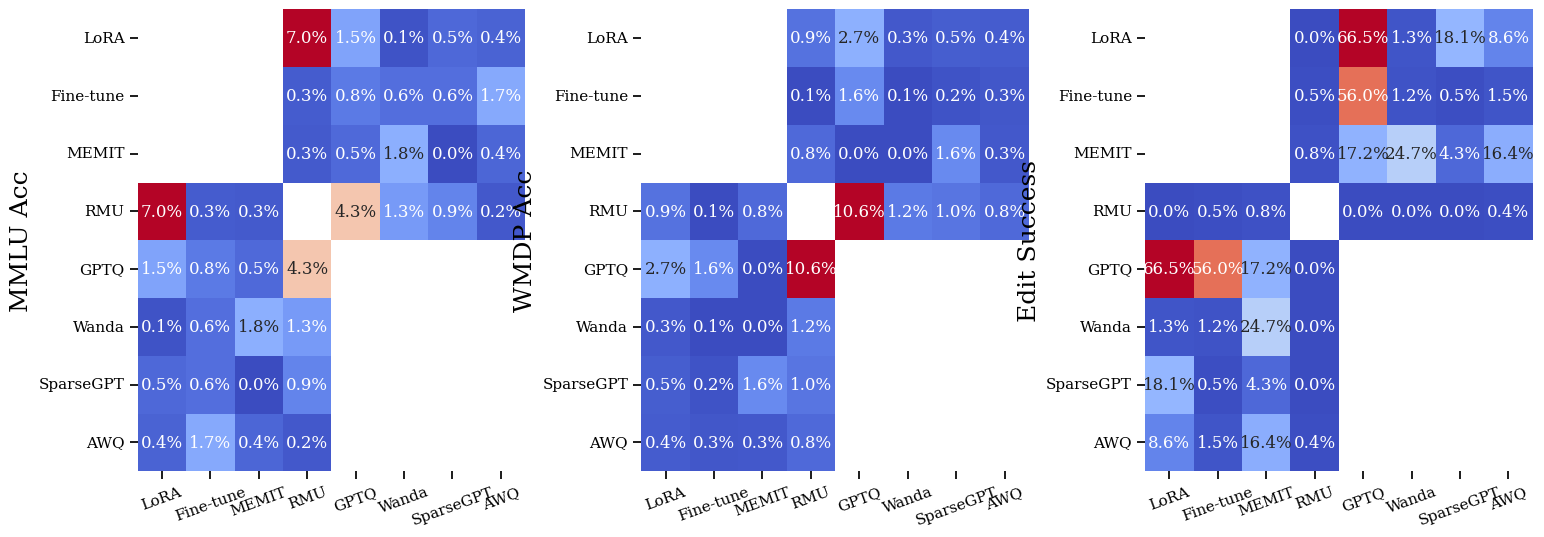

In [11]:
# Create three heatmaps next two eachother, one for each frame
fig, axes = plt.subplots(1, 3, figsize=(6 * FIG_SIZE, 2 * FIG_SIZE))
y_labels = {
    0: "MMLU Acc",
    1: "WMDP Acc",
    2: "Edit Success"
}

sns.heatmap(mmlu_heatmap_data, annot=True, fmt=".1%", cmap="coolwarm", ax=axes[0], cbar=False)
sns.heatmap(wmdp_heatmap_data, annot=True, fmt=".1%", cmap="coolwarm", ax=axes[1], cbar=False)
sns.heatmap(rewrite_heatmap_data, annot=True, fmt=".1%", cmap="coolwarm", ax=axes[2], cbar=False)

# roate x labels
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=X_LABEL_ROTATION)

for i, ax in enumerate(axes):
    ax.set_ylabel(y_labels[i], fontsize=TITLE_FONT_SIZE)

# add padding for labels
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)

if not os.path.exists("figures"):
    os.makedirs("figures")

plt.savefig("figures/delta_heatmaps.pdf", bbox_inches="tight")

## Plot: Editing under Compression 

In [12]:
def get_order_label(row):
    interventions = row["interventions"]
    first_method = ""
    second_method = ""
    if interventions[0] == "edit":
        first_method = row["edit"]
    elif interventions[0] == "compress":
        first_method = row["compression"]
    elif interventions[0] == "unlearn":
        first_method = row["unlearn"]
    
    if interventions[1] == "edit":
        second_method = row["edit"]
    elif interventions[1] == "compress":
        second_method = row["compression"]
    elif interventions[1] == "unlearn":
        second_method = row["unlearn"]
    
    return f"{first_method}→{second_method}"

def wrap_label(interventions):
    first_intervention, second_intervention = interventions[0], interventions[1]
    first_letter_upper = first_intervention[0].upper()
    second_letter_upper = second_intervention[0].upper()
    
    # EX: E $\rightarrow$ C
    return f"{first_letter_upper}$\\rightarrow${second_letter_upper}"


### Create mock records for baselines

In [13]:
# I want instances where editing has been applied but there is no unlearning or compression. In these cases, set wbits=16 and sparsity=0 
baseline_editors = data[(data["edit"].notnull()) & (data["unlearn"].isnull()) & (data["compression"].isnull()) & (data["interventions"].apply(lambda x: x == ["edit"]))].copy()
baseline_editors["wbits"] = 16
baseline_editors["sparsity_ratio"] = 0
news_records = []

# Edit and Compress
for editing_method in ["LoRA", "MEMIT", "Fine-tune"]:
    baseline_record = baseline_editors[baseline_editors["edit"] == editing_method]
    for compression_method in ["SparseGPT", "Wanda", "GPTQ", "AWQ"]:
        edit_first_record = baseline_record.copy()
        edit_first_record["compression"] = compression_method
        edit_first_record["interventions"] = [["edit", "compress"]]
        news_records.append(edit_first_record)

        compress_first_record = baseline_record.copy()
        compress_first_record["compression"] = compression_method
        compress_first_record["interventions"] = [["compress", "edit"]]
        news_records.append(compress_first_record)

baseline_unlearners = data[(data["edit"].isnull()) & (data["unlearn"].notnull()) & (data["compression"].isnull()) & (data["interventions"].apply(lambda x: x == ["unlearn"]))].copy()

# Compress and Unlearn
for unlearn_method in ["RMU"]:
    baseline_record = baseline_unlearners[baseline_unlearners["unlearn"] == unlearn_method]

    for compression_method in ["SparseGPT", "Wanda", "GPTQ", "AWQ"]:
        compress_first_record = baseline_record.copy()
        compress_first_record["unlearn"] = unlearn_method
        compress_first_record["compression"] = compression_method
        compress_first_record["interventions"] = [["compress", "unlearn"]]
        news_records.append(compress_first_record)

        unlearn_first_record = baseline_record.copy()
        unlearn_first_record["unlearn"] = unlearn_method
        unlearn_first_record["compression"] = compression_method
        unlearn_first_record["interventions"] = [["unlearn", "compress"]]
        news_records.append(unlearn_first_record)

baseline_records = pd.concat(news_records)

### Combined Pruning and Quantization

In [14]:
# Add mock baseline records to the frame used for plotting
data = pd.concat([data, baseline_records])

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_99252/2075301458.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_line["label"] = first_line["order"].apply(wrap_label)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_99252/2075301458.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_line["label"] = first_line["order"].apply(wrap_label)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_99252/2075301458.py:49: SettingWithCopyWarning: 
A value is trying to be se

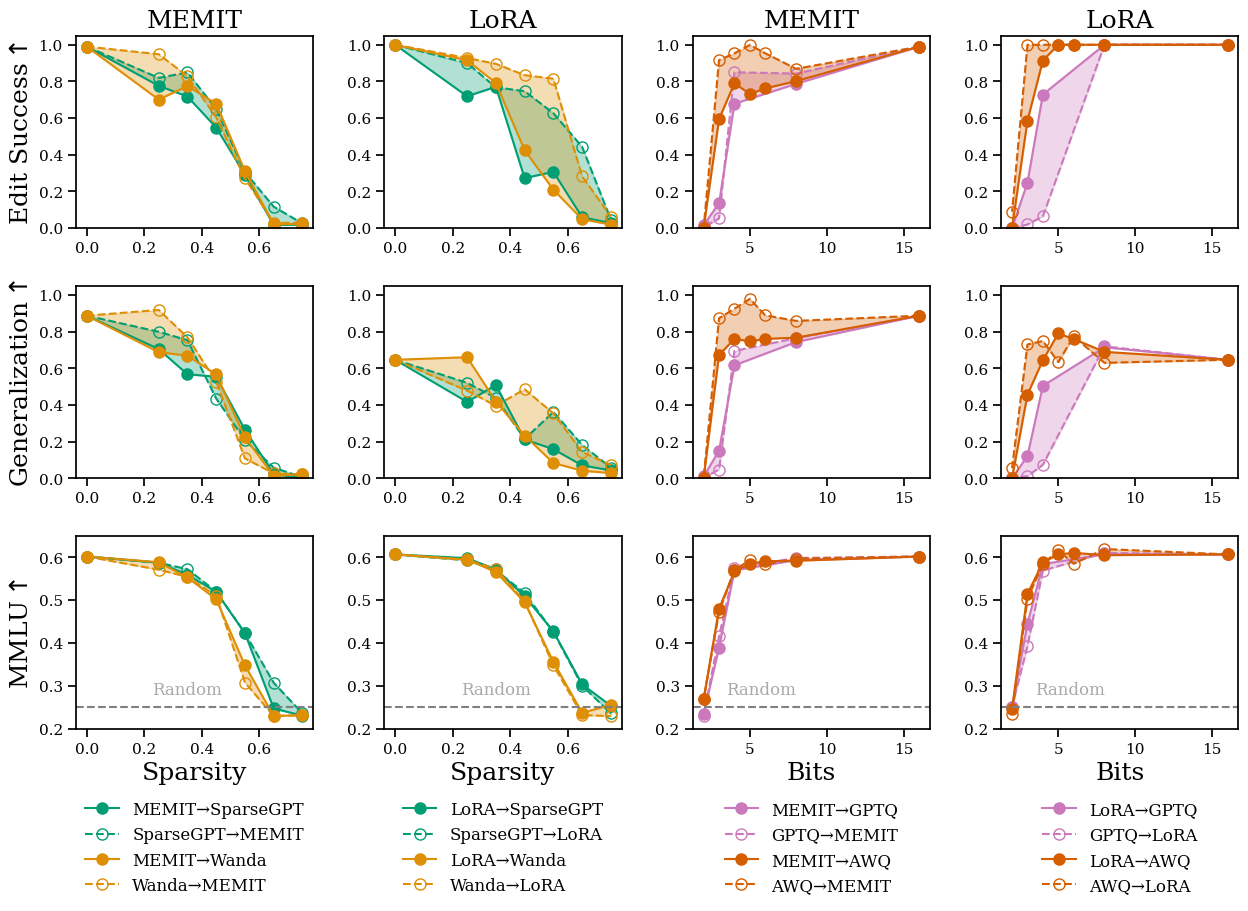

In [15]:
pruning_frame = data[((data["compression"] == "SparseGPT") | (data["compression"] == "Wanda")) & (data["edit"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
pruning_frame = pruning_frame[pruning_frame["edit"] != "Fine-tune"]
pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
pruning_frame = pruning_frame.sort_values(by="order")

quantization_frame = data[((data["compression"] == "GPTQ") | (data["compression"] == "AWQ")) & (data["edit"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
quantization_frame = quantization_frame[quantization_frame["edit"] != "Fine-tune"]
quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
quantization_frame = quantization_frame.sort_values(by="order")

# 4 columns and 3 rows
fig, axes = plt.subplots(3, 4, figsize=(5 * FIG_SIZE, 3 * FIG_SIZE))
row_metrics = {
    0: "Rewrite accuracy",
    1: "Generalization",
    2: "mmlu accuracy",
}
row_labels = {
    0: r"Edit Success$ \uparrow$",
    1: r"Generalization$ \uparrow$",
    2: r"MMLU$ \uparrow$"
}
column_edit_methods = {
    0: "MEMIT",
    1: "LoRA",
    2: "MEMIT",
    3: "LoRA",
}

compositions_by_col = {
    # MEMIT and WANDA + SparseGPT
    0: [("MEMIT→SparseGPT", "SparseGPT→MEMIT"), ("MEMIT→Wanda", "Wanda→MEMIT")],
    # LoRA and WANDA + SparseGPT
    1: [("LoRA→SparseGPT", "SparseGPT→LoRA"), ("LoRA→Wanda", "Wanda→LoRA")],
    # MEMIT and GPTQ + AWQ
    2: [("MEMIT→GPTQ", "GPTQ→MEMIT"), ("MEMIT→AWQ", "AWQ→MEMIT")],
    # LoRA and GPTQ + AWQ
    3: [("LoRA→GPTQ", "GPTQ→LoRA"), ("LoRA→AWQ", "AWQ→LoRA")],
}
for row_index, y_metric in row_metrics.items():
    for col_index, plotting_frame in enumerate([pruning_frame, pruning_frame, quantization_frame, quantization_frame]):
        ax = axes[row_index][col_index]
        x_metric = "sparsity_ratio" if col_index < 2 else "wbits"
        plotting_frame = plotting_frame[plotting_frame["edit"] == column_edit_methods[col_index]]

        for composition in compositions_by_col[col_index]:
            compression_method = [method for method in composition[0].split("→") if method not in ["MEMIT", "LoRA", "Fine-tune"]][0]
            first_line = plotting_frame[plotting_frame["order"] == composition[0]]
            first_line["label"] = first_line["order"].apply(wrap_label)
            second_line = plotting_frame[plotting_frame["order"] == composition[1]].sort_values(x_metric)
            second_line["label"] = second_line["order"].apply(wrap_label)
            if compression_method in ["AWQ", "GPTQ"]:
                first_line = first_line.sort_values(x_metric, ascending=False)
                second_line = second_line.sort_values(x_metric, ascending=False)
            else:
                first_line = first_line.sort_values(x_metric)
                second_line = second_line.sort_values(x_metric)

            ax.plot(first_line[x_metric], first_line[y_metric], marker="o", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[0]}")
            ax.plot(second_line[x_metric], second_line[y_metric], markerfacecolor='none', marker="o", ls="--", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[1]}")
            ax.fill_between(
                x=first_line[x_metric], y1=first_line[y_metric], y2=second_line[y_metric],
                alpha=0.3,
                color=colors[compression_method]
            )

        if row_index != 2:
            ax.set_ylim(0, 1.05)
        else:
            ax.set_ylim(0.2, 0.65)
            ax.axhline(y=0.25, color="gray", linestyle="--")
            if col_index < 2:
                ax.text(0.35, 0.28, "Random", color="darkgray", ha="center")
            else:
                ax.text(8, 0.28, "Random", color="darkgray", ha="right")

        if row_index == 0:
            title = column_edit_methods[col_index]
            ax.set_title(title, fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_title("")

        if col_index == 0:
            ax.set_ylabel(row_labels[row_index], fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_ylabel("")

        if row_index == 2:
            ax.set_xlabel("Sparsity" if col_index < 2 else "Bits", fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_xlabel("")

        if row_index == 2:
            ax.legend(fontsize=LEGEND_FONT_SIZE, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=1)

fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
plt.savefig("figures/main_results_editors_compression.pdf", bbox_inches="tight")

### 3 X 3 for Pruning and Quantization (Two Plots)

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_99252/458386737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with

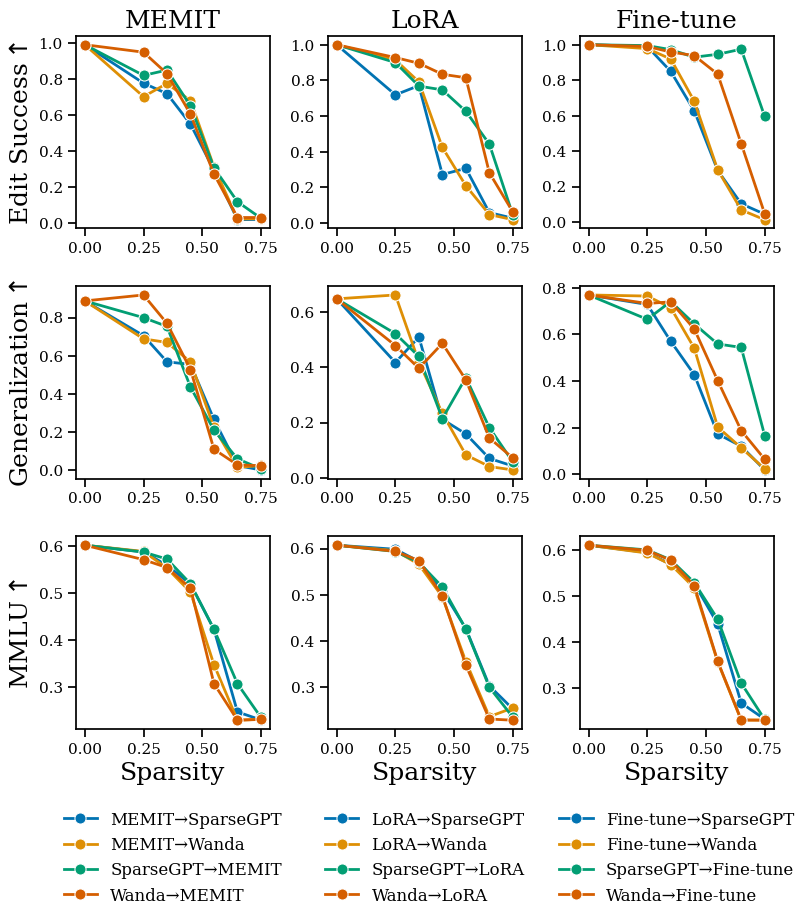

In [16]:
pruning_frame = data[((data["compression"] == "SparseGPT") | (data["compression"] == "Wanda")) & (data["edit"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
pruning_frame = pruning_frame.sort_values(by="order")
fig, axes = plt.subplots(3, 3, figsize=(3 * FIG_SIZE, 3 * FIG_SIZE))
row_metrics = {
    0: "Rewrite accuracy",
    1: "Generalization",
    2: "mmlu accuracy",
}
row_labels = {
    0: r"Edit Success$ \uparrow$",
    1: r"Generalization$ \uparrow$",
    2: r"MMLU$ \uparrow$"
}
column_methods = {
    0: "MEMIT",
    1: "LoRA",
    2: "Fine-tune",
}
memit_frame = pruning_frame[pruning_frame["edit"] == "MEMIT"]
lora_frame = pruning_frame[pruning_frame["edit"] == "LoRA"]
fine_tune_frame = pruning_frame[pruning_frame["edit"] == "Fine-tune"]

for row_index, row_metric in row_metrics.items():
    for col_index, plotting_frame in enumerate([memit_frame, lora_frame, fine_tune_frame]):
        ax = axes[row_index][col_index]
        ax.legend(title="Order", loc="upper left")
        sns.lineplot(data=plotting_frame, x="sparsity_ratio", y=row_metric, hue="order", ax=ax, marker="o", markersize=MARKER_SIZE, linewidth=LINE_WIDTH)

        if row_index == 0:
            title = column_methods[col_index]
            ax.set_title(title, fontsize=TITLE_FONT_SIZE)
        if row_index != 2:
            ax.set_xlabel("")
            ax.get_legend().remove()
        else:
            ax.set_xlabel("Sparsity", fontsize=TITLE_FONT_SIZE)
            ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.35), ncol=1, frameon=False, fontsize=LEGEND_FONT_SIZE)
        
        if col_index == 0:
            ax.set_ylabel(row_labels[row_index], fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_ylabel("")
        
# add padding for labels
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
plt.savefig("figures/editing_compression_pruning_3x3.pdf", bbox_inches="tight")


/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_99252/683289178.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quant_frame["order"] = quant_frame.apply(get_order_label, axis=1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an 

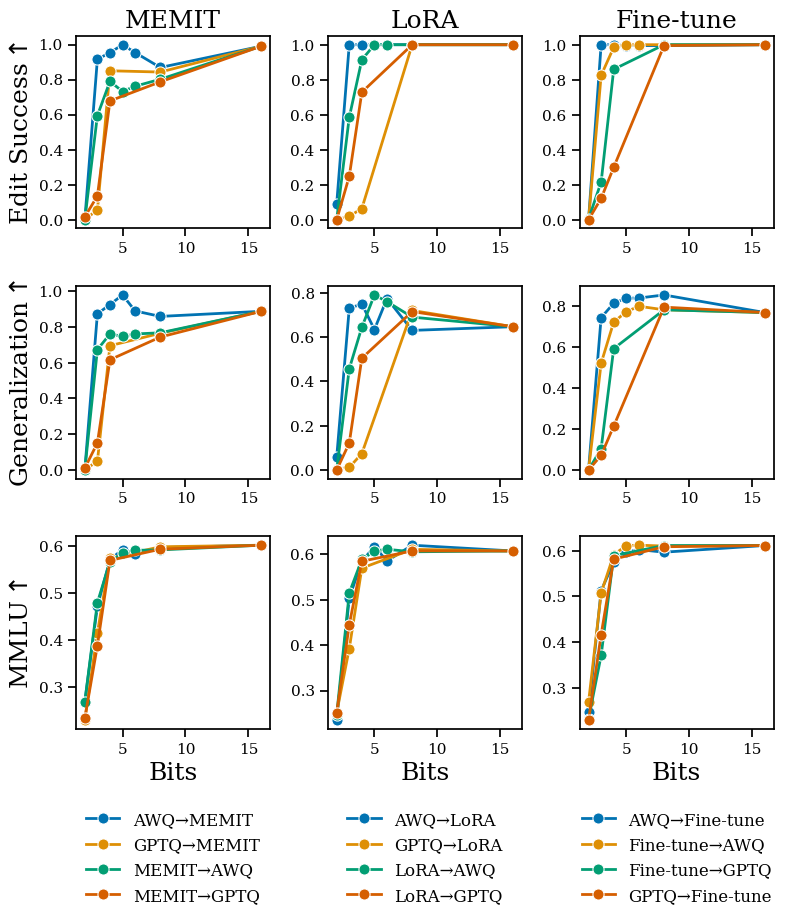

In [17]:
quant_frame = data[((data["compression"] == "AWQ") | (data["compression"] == "GPTQ")) & (data["edit"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
quant_frame["order"] = quant_frame.apply(get_order_label, axis=1)
quant_frame = quant_frame.sort_values(by="order")
fig, axes = plt.subplots(3, 3, figsize=(3 * FIG_SIZE, 3 * FIG_SIZE))
row_metrics = {
    0: "Rewrite accuracy",
    1: "Generalization",
    2: "mmlu accuracy",
}
row_labels = {
    0: r"Edit Success$ \uparrow$",
    1: r"Generalization$ \uparrow$",
    2: r"MMLU$ \uparrow$"
}
column_methods = {
    0: "MEMIT",
    1: "LoRA",
    2: "Fine-tune",
}
memit_frame = quant_frame[quant_frame["edit"] == "MEMIT"]
lora_frame = quant_frame[quant_frame["edit"] == "LoRA"]
fine_tune_frame = quant_frame[quant_frame["edit"] == "Fine-tune"]

for row_index, row_metric in row_metrics.items():
    for col_index, plotting_frame in enumerate([memit_frame, lora_frame, fine_tune_frame]):
        ax = axes[row_index][col_index]
        ax.legend(title="Order", loc="upper left")
        sns.lineplot(data=plotting_frame, x="wbits", y=row_metric, hue="order", ax=ax, marker="o", markersize=MARKER_SIZE, linewidth=LINE_WIDTH)

        if row_index == 0:
            title = column_methods[col_index]
            ax.set_title(title, fontsize=TITLE_FONT_SIZE)
        if row_index != 2:
            ax.set_xlabel("")
            ax.get_legend().remove()
        else:
            ax.set_xlabel("Bits", fontsize=TITLE_FONT_SIZE)
            ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.35), ncol=1, frameon=False, fontsize=LEGEND_FONT_SIZE)
        
        if col_index == 0:
            ax.set_ylabel(row_labels[row_index], fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_ylabel("")
        
# add padding for labels
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
plt.savefig("figures/editing_compression_quant_3x3.pdf", bbox_inches="tight")


## Plot: Unlearning under Compression 

### 2x2

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_99252/1285417393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["Avg WMDP"] = (pruning_frame["wmdp_bio accuracy"] + pruning_frame["wmdp_cyber accuracy"]) / 2
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_99252/1285417393.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_99252/1285417393.py

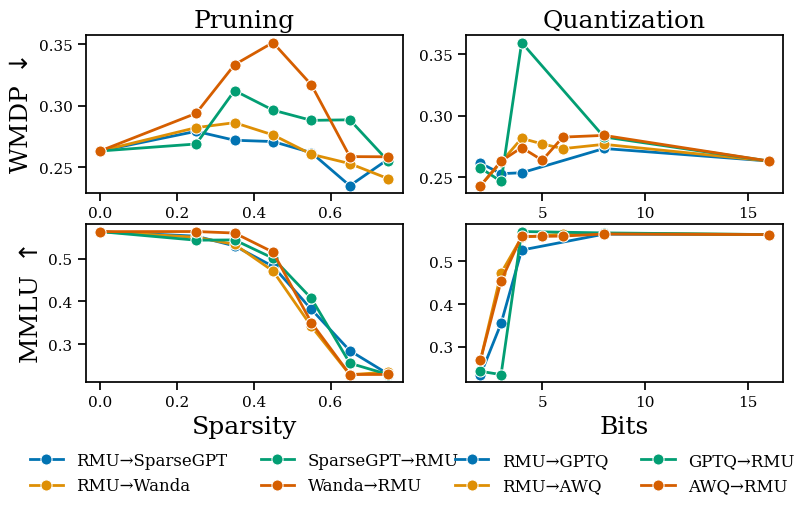

In [18]:
pruning_frame = data[((data["compression"] == "SparseGPT") | (data["compression"] == "Wanda")) & (data["unlearn"] == "RMU")]
pruning_frame["Avg WMDP"] = (pruning_frame["wmdp_bio accuracy"] + pruning_frame["wmdp_cyber accuracy"]) / 2
pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
pruning_frame = pruning_frame.sort_values(by="order")

quantization_frame = data[((data["compression"] == "GPTQ") | (data["compression"] == "AWQ")) & (data["unlearn"] == "RMU")]
quantization_frame["Avg WMDP"] = (quantization_frame["wmdp_bio accuracy"] + quantization_frame["wmdp_cyber accuracy"]) / 2
quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
quantization_frame = quantization_frame.sort_values(by="order", ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(3 * FIG_SIZE, 1.5 * FIG_SIZE))
row_metrics = {
    0: "Avg WMDP",
    1: "mmlu accuracy",
}
row_labels = {
    0: r"WMDP $\downarrow$",
    1: r"MMLU $\uparrow$"
}

for row_index, row_metric in row_metrics.items():
    for col_index, plotting_frame in enumerate([pruning_frame, quantization_frame]):
        x_metric = "sparsity_ratio" if col_index == 0 else "wbits"
        ax = axes[row_index][col_index]
        ax.legend(title="Order", loc="upper left")
        sns.lineplot(data=plotting_frame, x=x_metric, y=row_metric, hue="order", ax=ax, marker="o", markersize=MARKER_SIZE, linewidth=LINE_WIDTH)

        if row_index == 0:
            title = "Pruning" if col_index == 0 else "Quantization"
            ax.set_title(title, fontsize=TITLE_FONT_SIZE)
            ax.set_xlabel("")
            ax.get_legend().remove()
        else:
            x_label = "Sparsity" if col_index == 0 else "Bits"
            ax.set_xlabel(x_label, fontsize=TITLE_FONT_SIZE)
            ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.35), ncol=2, frameon=False, fontsize=LEGEND_FONT_SIZE)
        
        if col_index == 0:
            y_label = row_labels[row_index]
            ax.set_ylabel(y_label, fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_ylabel("")
        
# add padding for labels
fig.subplots_adjust()
plt.savefig("figures/unlearning_compression_2x2.pdf", bbox_inches="tight")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


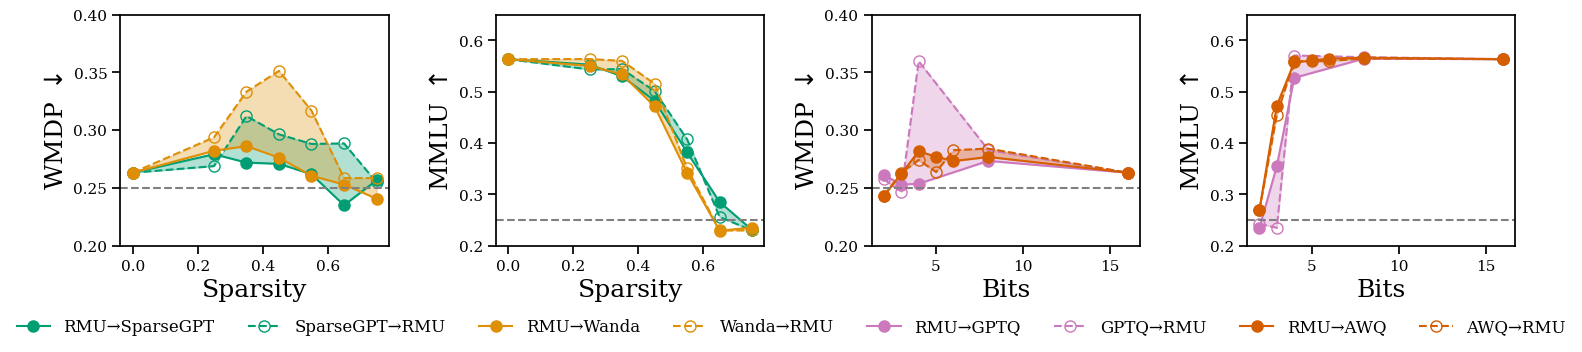

In [19]:
# Inspired by the 3X3 line charts in the existing paper

fig, axes = plt.subplots(1, 4, figsize=(6 * FIG_SIZE, FIG_SIZE))
column_metrics = {
    0: "Avg WMDP",
    1: "mmlu accuracy",
    2: "Avg WMDP",
    3: "mmlu accuracy",
}
x_labels = {
    "sparsity_ratio": "Sparsity",
    "wbits": "Bits"
}
y_label = {
    "Avg WMDP": r"WMDP $\downarrow$",
    "mmlu accuracy": r"MMLU $\uparrow$"
}

# Custom legend elements
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=MARKER_SIZE, label='Edit→Compress'),
    plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='r', markersize=MARKER_SIZE, label='Compress→Edit'),
]

for col_index, plotting_frame in enumerate([pruning_frame, pruning_frame, quantization_frame, quantization_frame]):
    x_metric = "sparsity_ratio" if col_index < 2 else "wbits"
    y_metric = "Avg WMDP" if col_index % 2 == 0 else "mmlu accuracy"
    ax = axes[col_index]
    ax.legend(title="Order", loc="upper left")
    # sns.lineplot(data=plotting_frame, x=x_metric, y=y_metric, hue="order", ax=ax, marker="o", markersize=MARKER_SIZE, linewidth=LINE_WIDTH)

    # Share area between compositions
    orders_pairs = [("RMU→SparseGPT", "SparseGPT→RMU"), ("RMU→Wanda", "Wanda→RMU"), ("RMU→GPTQ", "GPTQ→RMU"), ("RMU→AWQ", "AWQ→RMU")]
    for order_pair in orders_pairs:
        compression_method = [method for method in order_pair[0].split("→") if method != "RMU"][0]
        first_line = plotting_frame[plotting_frame["order"] == order_pair[0]].sort_values(x_metric)
        ax.plot(first_line[x_metric], first_line[y_metric], marker="o", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{order_pair[0]}")
        
        second_line = plotting_frame[plotting_frame["order"] == order_pair[1]].sort_values(x_metric)
        ax.plot(second_line[x_metric], second_line[y_metric], markerfacecolor='none', marker="o", ls="--", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{order_pair[1]}")
        
        ax.fill_between(
            x=first_line[x_metric], y1=first_line[y_metric], y2=second_line[y_metric],
            alpha=0.3,
            color=colors[compression_method]
        )

    ax.set_xlabel(x_labels[x_metric], fontsize=TITLE_FONT_SIZE)
    ax.set_ylabel(y_label[column_metrics[col_index]], fontsize=TITLE_FONT_SIZE)

    ax.legend(frameon=False)
    if col_index == 0:
        ax.legend(loc="upper center", bbox_to_anchor=(2.5, -0.25), ncol=8, frameon=False, fontsize=LEGEND_FONT_SIZE)
    else:
        ax.get_legend().remove()

    ax.axhline(y=0.25, color="gray", linestyle="--")

    if y_metric == "mmlu accuracy":
        ax.set_ylim(0.2, 0.65)
    else:
        ax.set_ylim(0.2, 0.4)

# add padding for labels
fig.subplots_adjust(wspace=WSPACE + 0.1, hspace=WSPACE)
plt.savefig("figures/unlearning_compression_1x4.pdf", bbox_inches="tight")
